In [2]:
import cv2
import numpy as np
from numpy import clip
import matplotlib.pyplot as plt
import os

import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn.functional as F
# from torchvision.transforms.functional import pad
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from diffusers import DDPMPipeline, DDPMScheduler, UNet2DModel
from diffusers.optimization import get_cosine_schedule_with_warmup

from tqdm import tqdm

/home/telejkoi/anaconda3/envs/dl2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
GLOBAL_MEAN = np.load("data/global_mean.npy")/255
GLOBAL_STD = np.load("data/global_std.npy")/255

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

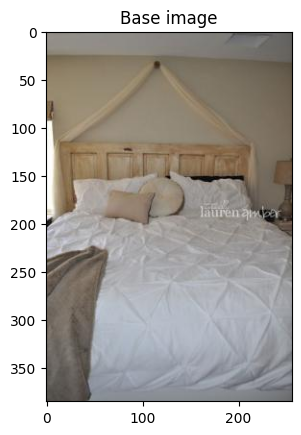

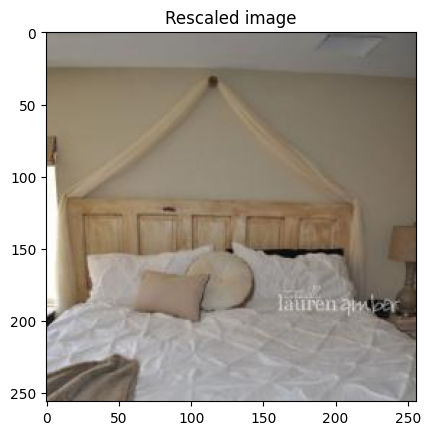

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


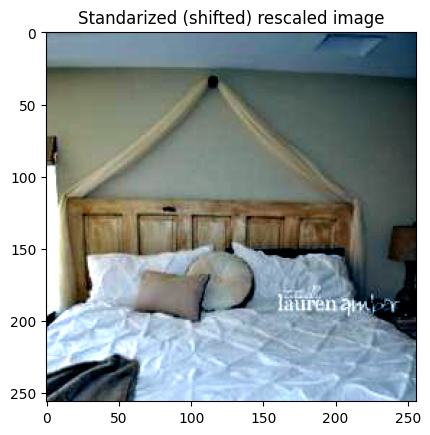

In [9]:
PATH = 'data/data0/lsun/bedroom/0/1/0/010bef28fa1b57d780fa1aac6fcdd054ce6c9fe2.jpg'

img = cv2.imread(PATH)
plt.imshow(img[:,:,::-1])
plt.title("Base image")
plt.show()

size = min(img.shape[:2])
resized = cv2.resize(img[:size,:size,:], (256, 256))/255.0
plt.imshow(resized[:,:,::-1])
plt.title("Rescaled image")
plt.show()

standarized = (resized - GLOBAL_MEAN) / GLOBAL_STD
# standarized = clip((resized - resized.mean(axis=(0,1))) / resized.std(axis=(0,1)), -1, 1)
standarized = (standarized + 1) / 2
plt.imshow(standarized[:,:,::-1])
plt.title("Standarized (shifted) rescaled image")
plt.show()

In [4]:
# def preprocess_image(image):
#     size = min(image.shape[:2])
#     image = image[:size,:size,:]
#     resized = cv2.resize(image, (256, 256)) / 255.0
#     standarized = clip((resized - resized.mean(axis=(0,1))) / resized.std(axis=(0,1)), -1, 1)
#     standarized = (standarized + 1) / 2
#     return standarized

# def prepare_data(data_path):
#     datasets = []
#     subdirs = [str(i) for i in range(10)] + ["a", "b", "c", "d", "e", "f"]
#     subdir1='0'
#     for subdir2 in tqdm(subdirs, f"Processing top dir {subdir1}"):
#         images = []
#         for subdir3 in subdirs:
#             img_subdir = os.path.join(data_path, subdir2, subdir3)
#             for filename in os.listdir(img_subdir):
#                 img = cv2.imread(os.path.join(img_subdir, filename))
#                 img = preprocess_image(img)
#                 images.append(img)
#         datasets.append(TensorDataset(torch.tensor(np.array(images))))
#         del images
#     return datasets

In [5]:
# class CustomDataset(Dataset):
#     def __init__(self, data_path, transform=None):
#         self.data_path = data_path
#         self.subdirs = [str(i) for i in range(10)] + ["a", "b", "c", "d", "e", "f"]
#         self.transform = transform
#         self.init_indices()

#     def __len__(self):
#         total_count = 0
#         for subdir1 in self.subdirs:
#             for subdir2 in self.subdirs:
#                 for subdir3 in self.subdirs:
#                     img_subdir = os.path.join(self.data_path, subdir1, subdir2, subdir3)
#                     total_count += len(os.listdir(img_subdir))
#         return total_count

#     def __getitem__(self, idx):
#         img = cv2.imread(self.indices[idx])
#         img = self.preprocess_image(img)
#         if self.transform:
#             img = self.transform(img)
#         return img

#     def init_indices(self):
#         self.indices = {}
#         subdirs = [str(i) for i in range(10)] + ["a", "b", "c", "d", "e", "f"]
#         index = 0
#         for subdir1 in subdirs:
#             for subdir2 in subdirs:
#                 for subdir3 in subdirs:
#                     img_subdir = os.path.join(data_path, subdir1, subdir2, subdir3)
#                     for filename in os.listdir(img_subdir):
#                         self.indices[index] = os.path.join(img_subdir, filename)
#                         index += 1

#     def preprocess_image(self, image):
#         size = min(image.shape[:2])
#         image = image[:size, :size, :]
#         resized = cv2.resize(image, (256, 256)) / 255.0
#         standarized = np.clip((resized - resized.mean(axis=(0, 1))) / resized.std(axis=(0, 1)), -1, 1)
#         standarized = (standarized + 1) / 2
#         return standarized

# data_path = 'data/data0/lsun/bedroom'
# custom_dataset = CustomDataset(data_path)

In [8]:
# class SquarePad:
# 	def __call__(self, image):
# 		w, h = image.size
# 		max_wh = np.max([w, h])
# 		hp = int((max_wh - w) / 2)
# 		vp = int((max_wh - h) / 2)
# 		padding = (hp, vp, hp, vp)
# 		return pad(image, padding, 0, 'constant')

# Define transformations
transform = transforms.Compose([
    # SquarePad(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=GLOBAL_MEAN, std=GLOBAL_STD),
    # transforms.Lambda(lambda x: torch.clamp((x+1)/2, min=0, max=1))  # Clip tensor values
])

# Path to your dataset directory
data_path = 'data/data0/lsun/bedroom'
batch_size = 16

image_dataset = ImageFolder(root=data_path, transform=transform)
image_dataset = Subset(image_dataset, torch.randperm(len(image_dataset))[:10000])
train_dataloader = DataLoader(image_dataset, batch_size=batch_size, shuffle=True)

for idx, batch in enumerate(train_dataloader):
    break


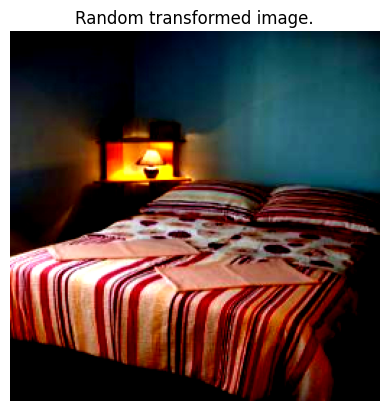

In [9]:
plt.imshow(batch[0][np.random.randint(0, batch_size)].permute(1, 2, 0))
plt.title("Random transformed image.")
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


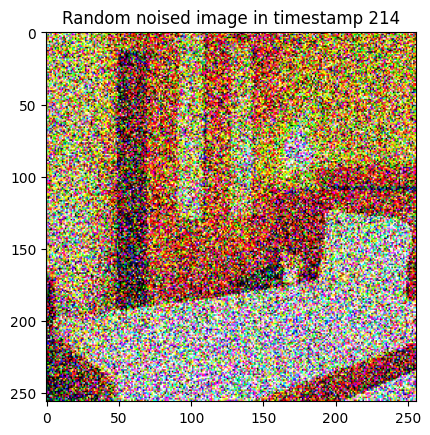

In [10]:
scheduler_timesteps = 1000

def plot_image_with_noise(image, scheduler_timesteps):
    batch_size=64
    noise_scheduler = DDPMScheduler(num_train_timesteps=scheduler_timesteps)
    noise = torch.randn((3, 256, 256))
    timesteps = torch.LongTensor([np.random.randint(0, scheduler_timesteps)])
    noisy_image = noise_scheduler.add_noise(image[np.random.randint(0, batch_size)], noise, timesteps).float()
    plt.imshow(noisy_image.permute(1, 2, 0).numpy())
    plt.title(f"Random noised image in timestamp {timesteps[0]}")
    plt.show()

plot_image_with_noise(batch[0], scheduler_timesteps)

In [11]:
model = UNet2DModel(
    sample_size=(256, 256),  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=1,  # how many ResNet layers to use per UNet block
    block_out_channels=[32],  # the number of output channels for each UNet block
    # block_out_channels=(128, 128, 256, 256, 512, 512)
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        # "DownBlock2D",
        # "DownBlock2D",
        # "DownBlock2D",
        # "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        # "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        # "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        # "UpBlock2D",
        # "UpBlock2D",
        # "UpBlock2D",
        # "UpBlock2D",
    ),
).to(device)

In [12]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
noise_scheduler = DDPMScheduler(num_train_timesteps=scheduler_timesteps)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=100,
    num_training_steps=(len(train_dataloader) * 1),
)

In [13]:
for epoch in range(2):
    for batch in tqdm(train_dataloader, f"Epoch: {epoch}"):
        optimizer.zero_grad()
        clean_images = batch[0].to(device)
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device
        ).long()

        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps).float()
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
        
        loss = F.mse_loss(noise_pred, noise)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

Epoch: 0:   0%|          | 3/625 [13:51<50:06:22, 290.00s/it]

In [21]:
pipeline = DDPMPipeline(unet=model, scheduler=noise_scheduler)

In [24]:
images = pipeline(
            batch_size=8,
            generator=torch.manual_seed(123),
        ).images

ValueError: `num_inference_steps`: 1000 cannot be larger than `self.config.train_timesteps`: 200 as the unet model trained with this scheduler can only handle maximal 200 timesteps.